In [17]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Multiply, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# ======================
# 1. Dataset Preparation
# ======================
train_dir = '/kaggle/input/brain-tumor-classification-mri/Training'
test_dir = '/kaggle/input/brain-tumor-classification-mri/Testing'

# ======================
# 2. Data Loading & Augmentation
# ======================
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

class_names = list(train_data.class_indices.keys())
print(f"Classes: {class_names}")

# ======================
# 3. Correct F1-Score Implementation
# ======================
def f1_score(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=1)
    y_true = tf.argmax(y_true, axis=1)
    
    f1s = []
    
    for class_idx in range(len(class_names)):
        # Create binary masks
        tp = tf.reduce_sum(tf.cast((y_true == class_idx) & (y_pred == class_idx), tf.float32))
        fp = tf.reduce_sum(tf.cast((y_pred == class_idx) & (y_true != class_idx), tf.float32))
        fn = tf.reduce_sum(tf.cast((y_true == class_idx) & (y_pred != class_idx), tf.float32))
        

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        

        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
        f1s.append(f1)

    return tf.reduce_mean(f1s)

# 4. Model Architecture

def se_block(input_tensor, ratio=16):
    channels = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, channels))(se)
    se = Dense(channels//ratio, activation='relu')(se)
    se = Dense(channels, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

def build_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights='imagenet'
    )
    for layer in base_model.layers[:int(len(base_model.layers)*0.4)]:
        layer.trainable = False
    
    x = base_model.output
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.3)(x)
    outputs = Dense(4, activation='softmax', kernel_regularizer=l2(0.001))(x)
    
    return Model(inputs=base_model.input, outputs=outputs)

# ======================
# 5. Training Configuration
# ======================
# Class weights for imbalance

class_weights = compute_class_weight('balanced',
                                    classes=np.unique(train_data.classes),
                                    y=train_data.classes)
class_weights = dict(enumerate(class_weights))

model = build_model()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        f1_score,
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

callbacks = [
     ModelCheckpoint(
        'best_model.weights.h5',     # ✅ Correct extension for weights-only saving
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1,
        save_weights_only=True       # ✅ Required when saving only weights
    ),

    EarlyStopping(monitor='val_accuracy',
                patience=15,
                restore_best_weights=True,
                mode='max')
]

# ======================
# 6. Model Training
# ======================
history = model.fit(
    train_data,
    epochs=50,
    validation_data=test_data,
    class_weight=class_weights,
    callbacks=callbacks
)

# ======================
model.save('/kaggle/working/brain_tumor_model.h5')
print("Model saved to /kaggle/working/brain_tumor_model.h5")

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.4451 - f1_score: 0.4146 - loss: 1.4514 - precision: 0.5862 - recall: 0.1965
Epoch 1: val_accuracy improved from -inf to 0.38579, saving model to best_model.weights.h5
90/90 ━━━━━━━━━━━━━━━━━━━━ 97s 622ms/step - accuracy: 0.4484 - f1_score: 0.4182 - loss: 1.4455 - precision: 0.5902 - recall: 0.2007 - val_accuracy: 0.3858 - val_f1_score: 0.1192 - val_loss: 1.9553 - val_precision: 0.4042 - val_recall: 0.3426
Epoch 2/50
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.8156 - f1_score: 0.8020 - loss: 0.7230 - precision: 0.8550 - recall: 0.7665
Epoch 2: val_accuracy improved from 0.38579 to 0.40863, saving model to best_model.weights.h5
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 422ms/step - accuracy: 0.8159 - f1_score: 0.8023 - loss: 0.7221 - precision: 0.8550 - recall: 0.7670 - val_accuracy: 0.4086 - val_f1_score: 0.1348 - val_loss: 2.3390 - val_precision: 0.4302 - val_recall: 0.3909
Epoch 3/50
89/90 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accu

In [ ]:
model.summary()

Model: "functional_4"

 Trainable params: 2,530,388 (9.65 MB)

 Non-trainable params: 98,240 (383.75 KB)

 Optimizer params: 5,060,778 (19.31 MB)

Preprocessing steps


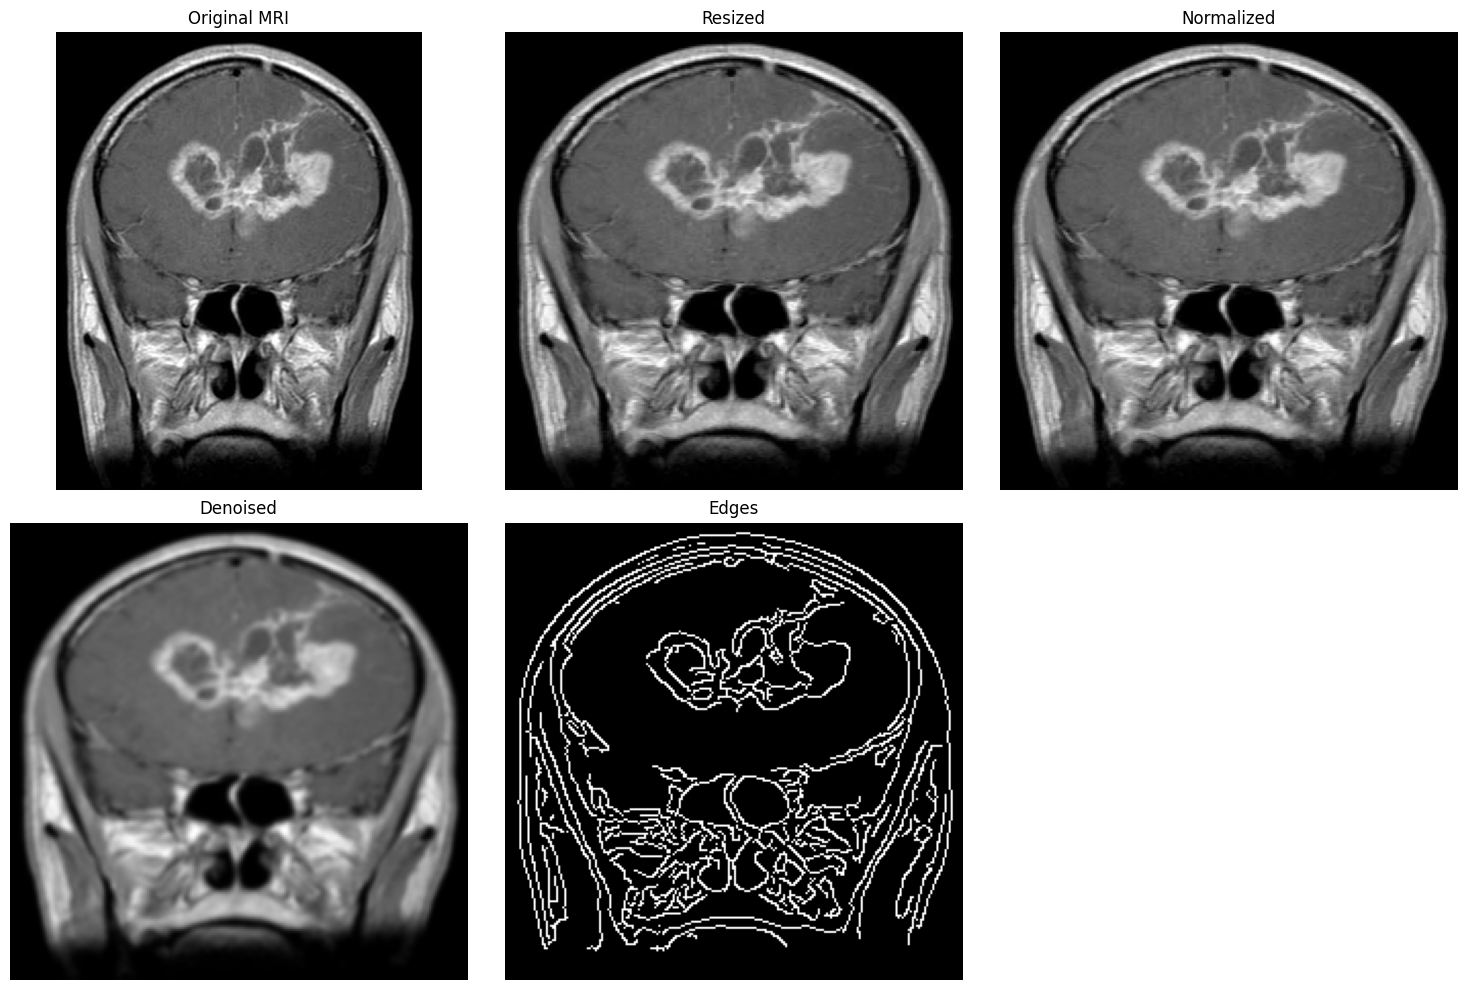

In [1]:
# print("Preprocessing steps")
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load the uploaded image
img_path = "/kaggle/input/brain-tumor-classification-mri/Testing/glioma_tumor/image(1).jpg"
original_img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

# Step a: Resizing
resized_img = cv2.resize(original_img, (224, 224))

# Step b: Normalization
normalized_img = resized_img / 255.0

# Step c: Noise Reduction (Gaussian Blur)
denoised_img = cv2.GaussianBlur((normalized_img * 255).astype(np.uint8), (5, 5), 0)

# Step d: Edge Detection (Canny Filter)
edges_img = cv2.Canny(denoised_img, threshold1=50, threshold2=150)

# Step 3: Feature Extraction (Simulated via Gabor filter)
def apply_gabor_filters(img):
    kernels = []
    for theta in np.arange(0, np.pi, np.pi / 4):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kernels.append(kernel)
    accum = np.zeros_like(img, dtype=np.float32)
    for kernel in kernels:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        accum = np.maximum(accum, fimg.astype(np.float32))
    return accum.astype(np.uint8)

features_img = apply_gabor_filters(denoised_img)

# Display all steps
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs[0, 0].imshow(original_img, cmap='gray')
axs[0, 0].set_title("Original MRI")
axs[0, 1].imshow(resized_img, cmap='gray')
axs[0, 1].set_title("Resized")
axs[0, 2].imshow(normalized_img, cmap='gray')
axs[0, 2].set_title("Normalized")
axs[1, 0].imshow(denoised_img, cmap='gray')
axs[1, 0].set_title("Denoised")
axs[1, 1].imshow(edges_img, cmap='gray')
axs[1, 1].set_title("Edges")


for ax in axs.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [20]:
from tensorflow.keras.models import load_model

# If using custom metric like f1_score, pass it in custom_objects
model = load_model('/kaggle/input/brain-tumor-model/brain_tumor_model.h5')

# Step 3: Compile the model again with custom F1-score metric
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
    ]
)

test_loss, test_accuracy = model.evaluate(test_data)
# Print the test accuracy
print(f"\nTest Accuracy: {test_accuracy:.4f}")

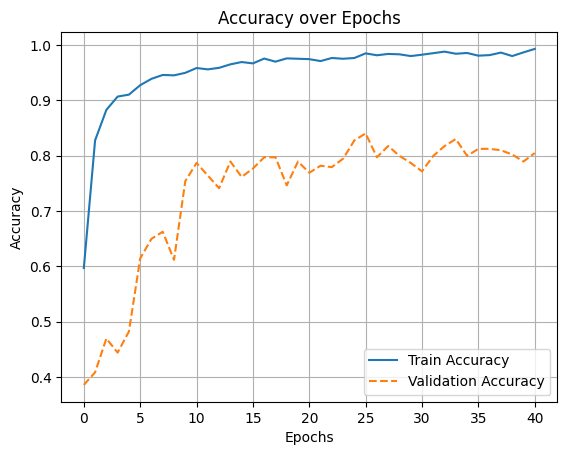

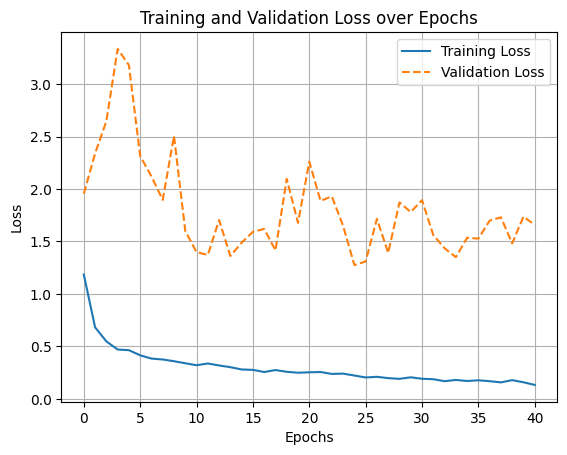

In [23]:
import matplotlib.pyplot as plt
import numpy as np
scaled_val_accuracy = np.array(history.history['val_accuracy'])

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(scaled_val_accuracy, label='Validation Accuracy', linestyle='--')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
val_loss_scaled = np.array(history.history['val_loss'])  
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(val_loss_scaled, label='Validation Loss', linestyle='--')

plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

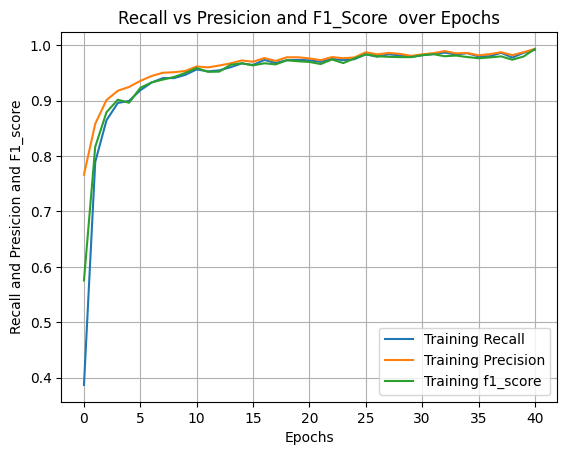

In [24]:
# Plot training and adjusted validation loss
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['f1_score'], label='Training f1_score')
plt.title('Recall vs Presicion and F1_Score  over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall and Presicion and F1_score')
plt.legend()
plt.grid(True)
plt.show()

Using last conv layer: Conv_1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted tumor type: meningioma_tumor


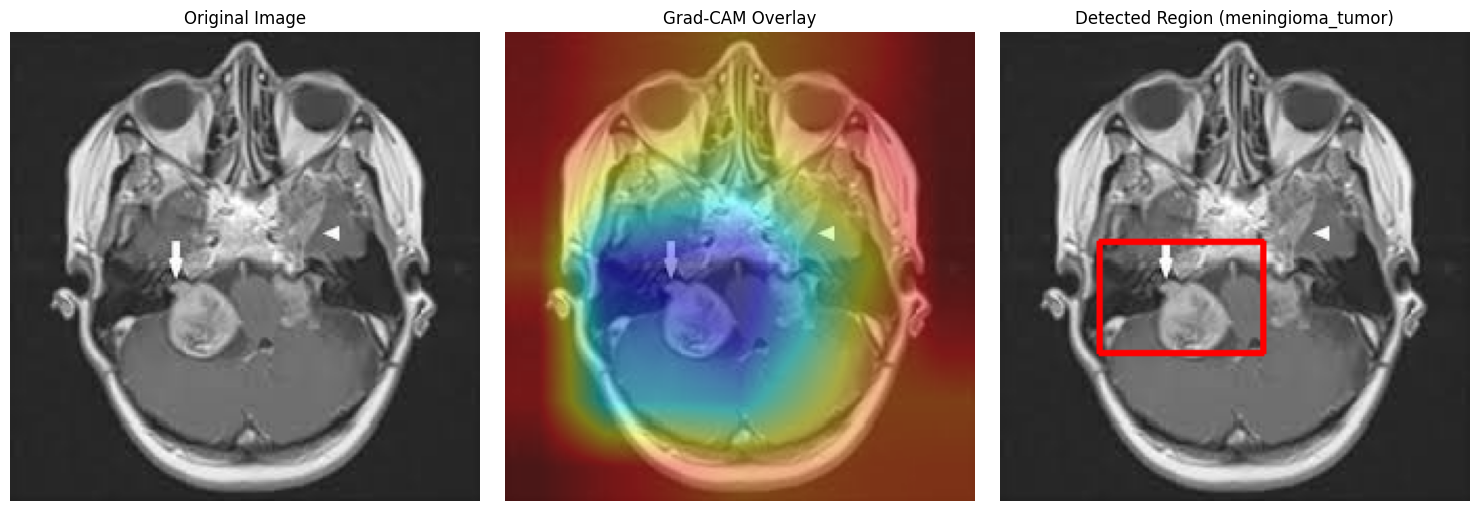

In [19]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define class names in the same order used during model training
class_names = ['glioma_tumor', 'meningioma_tumor', 'no_tumor','pituitary_tumor']

def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D) or 'depthwise' in layer.name.lower():
            return layer.name
    raise ValueError("Could not find a convolutional layer in the model.")

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def show_original_and_detected_area(image_path, model, threshold=0.85, min_contour_area=100):
    # Load and preprocess image
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img).astype(np.uint8)
    img_array_expanded = np.expand_dims(img_array, axis=0) / 255.0

    # Get last conv layer
    last_conv_layer_name = get_last_conv_layer_name(model)
    print(f"Using last conv layer: {last_conv_layer_name}")

    # Predict tumor class
    preds = model.predict(img_array_expanded)
    pred_class = np.argmax(preds[0])
    tumor_type = class_names[pred_class]
    print(f"Predicted tumor type: {tumor_type}")

    if tumor_type.lower() == "no_tumor":
        print("No tumor detected.")
        plt.imshow(img_array)
        plt.title("No Tumor Detected")
        plt.axis("off")
        plt.show()
        return

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img_array_expanded, model, last_conv_layer_name, pred_class)

    # Resize and blur the heatmap for better focus
    heatmap_resized = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
    heatmap_blurred = cv2.GaussianBlur(heatmap_resized, (5, 5), 0)

    # Create binary mask from blurred heatmap
    tumor_mask = (heatmap_blurred >= threshold).astype(np.uint8) * 255

    # Find contours
    contours, _ = cv2.findContours(tumor_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw only significant contours on original image
    img_with_mask = img_array.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area > min_contour_area:
            x, y, w, h = cv2.boundingRect(cnt)
            cv2.rectangle(img_with_mask, (x, y), (x + w, y + h), (255, 0, 0), 2)

    # Blend heatmap with original image
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay_img = cv2.addWeighted(img_array, 0.6, heatmap_colored, 0.4, 0)

    # Plot results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.axis('off')
    plt.imshow(img_array.astype(np.uint8))

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Overlay")
    plt.axis('off')
    plt.imshow(overlay_img)

    plt.subplot(1, 3, 3)
    plt.title(f"Detected Region ({tumor_type})")
    plt.axis('off')
    plt.imshow(img_with_mask)

    plt.tight_layout()
    plt.show()

# Example usage
# Make sure the model is loaded beforehand
# show_original_and_detected_area('/path/to/image.jpg', model)

# Usage example:
show_original_and_detected_area('/kaggle/input/brain-tumor-classification-mri/Testing/meningioma_tumor/image(100).jpg', model)